In [5]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [51]:
columns_labels = [ 'Device ID', 'accelerometer x', 'accelerometer y', 'accelerometer z',
    'gyroscope x', 'gyroscope y', 'gyroscope z', 'magnetometer x', 'magnetometer y', 'magnetometer z',
    'Timestamp', 'Activity Label']

activities = ['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk']

### 2. Read Files

In [12]:
def readFiles(ID):
    file = "part" + str(ID)
    pasta = "dataset\part" + str(ID)

    dev = [0]*5

    for i in range(5):
        f = file + "dev" + str(i+1) + ".csv"
        dir = os.path.join(pasta, f)
        dev[i] = np.genfromtxt(dir, delimiter=',')

    dFrame = pd.DataFrame(np.concatenate(dev), columns=columns_labels)

    return [np.concatenate(dev), dFrame]

[data, dataFrame] = readFiles(0)

### 3. Módulo

In [74]:
def modulo(dFrame):
    acc = []
    gir = []
    mag = []

    for i in range(16):
        activity = dFrame.loc[dFrame['Activity Label'] == i+1]
        acc += [pd.DataFrame(np.sqrt(activity['accelerometer x']**2 + activity['accelerometer y']**2 + activity['accelerometer x']**2), columns=[i+1])]

        activity = dFrame.loc[dFrame['Activity Label'] == i+1]
        gir += [pd.DataFrame(np.sqrt(activity['gyroscope x']**2 + activity['gyroscope y']**2 + activity['gyroscope x']**2), columns=[i+1])]

        activity = dFrame.loc[dFrame['Activity Label'] == i+1]
        mag += [pd.DataFrame(np.sqrt(activity['magnetometer x']**2 + activity['magnetometer y']**2 + activity['magnetometer x']**2), columns=[i+1])]

    acc = pd.concat(acc)
    gir = pd.concat(gir)
    mag = pd.concat(mag)

    return [acc, gir, mag]

[acc, gir, mag] = modulo(dataFrame)

### 3.1 Boxplot dos módulos

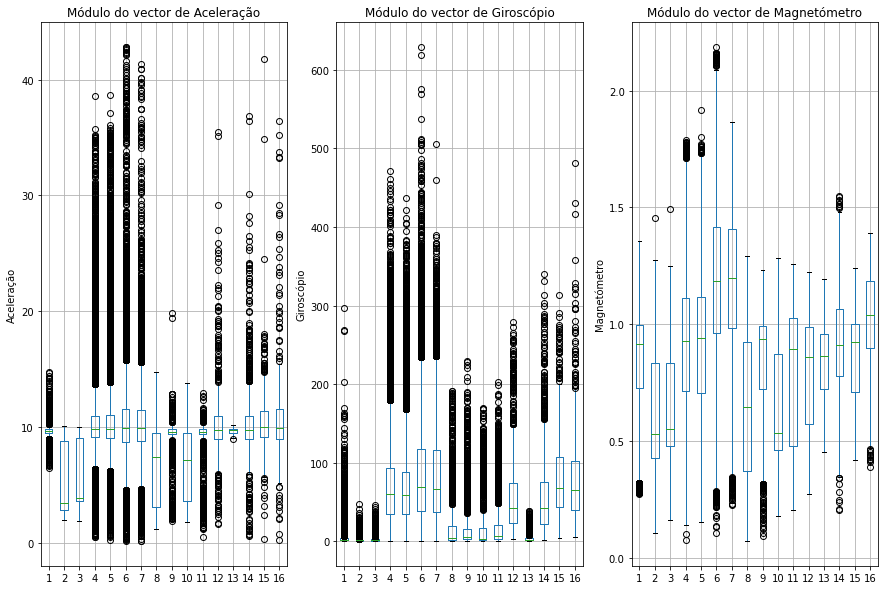

In [75]:
from gzip import FNAME


def boxplot(acc, gir, mag):

    plt.figure(figsize=(15,10))
    
    plt.subplot(1,3,1)
    plt.title("Módulo do vector de Aceleração")
    plt.ylabel("Aceleração")
    acc.boxplot()

    plt.subplot(1,3,2)
    plt.title("Módulo do vector de Giroscópio")
    plt.ylabel("Giroscópio")
    gir.boxplot()

    plt.subplot(1,3,3)
    plt.title("Módulo do vector de Magnetómetro")
    plt.ylabel("Magnetómetro")
    mag.boxplot()

    plt.savefig("modulos")

boxplot(acc, gir, mag)